In [15]:
%matplotlib inline

import malariagen_data
import allel
import numpy as np
import pandas as pd
import dask
from dask.diagnostics import ProgressBar
import zarr
from pathlib import Path
import scipy
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

### GAARDIAN - Ghana - G12

In [16]:
ag3 = malariagen_data.Ag3("gs://vo_agam_release/", pre=True)

In [17]:
df_sample_sets = ag3.sample_sets(release="v3.2")
df_sample_sets

,sample_set,sample_count,release
0,1177-VO-ML-LEHMANN-VMF00015,23,v3.2
1,1237-VO-BJ-DJOGBENOU-VMF00050,90,v3.2
2,1237-VO-BJ-DJOGBENOU-VMF00067,142,v3.2
3,1244-VO-GH-YAWSON-VMF00051,666,v3.2
4,1245-VO-CI-CONSTANT-VMF00054,38,v3.2
5,1253-VO-TG-DJOGBENOU-VMF00052,179,v3.2


Lets load the sample metadata and the SNP genotypes and positions. 

In [18]:
metadata = ag3.sample_metadata(sample_sets='1244-VO-GH-YAWSON-VMF00051')

phenotypes = pd.read_csv("gaard/sample_phenotypes.csv", sep="\t")

phenotypes = phenotypes.rename(columns={'specimen':'partner_sample_id'})

metadata = pd.merge(metadata, phenotypes, how='left')

How many do we have from each species?

In [19]:
metadata.species.value_counts()

gambiae                          398
coluzzii                         264
intermediate_gambiae_coluzzii      4
Name: species, dtype: int64

How many samples do we have from each village??

In [20]:
metadata.location.value_counts()

Korle-Bu    268
Madina      200
Obuasi      198
Name: location, dtype: int64

For each location, how many gambiae / coluzzii do we have?

In [21]:
pd.crosstab(metadata.location, metadata.phenotype)

phenotype,alive,dead
location,,
Korle-Bu,123,141
Madina,119,81
Obuasi,91,107


## G12

In [22]:
def cluster_G12(gnalt, cut_height=0.1, metric='euclidean'):
    """
    Hierarchically clusters genotypes and calculates G12 statistic. 
    """
    # cluster the genotypes in the window
    dist = scipy.spatial.distance.pdist(gnalt.T, metric=metric)
    if metric in {'hamming', 'jaccard'}:
        # convert distance to number of SNPs, easier to interpret
        dist *= gnalt.shape[0]

    Z = scipy.cluster.hierarchy.linkage(dist, method='single')
    cut = scipy.cluster.hierarchy.cut_tree(Z, height=cut_height)[:, 0]
    cluster_sizes = np.bincount(cut)
    clusters = [np.nonzero(cut == i)[0] for i in range(cut.max() + 1)]
    
    # get freq of clusters and sort by largest freq
    freqs = cluster_sizes/gnalt.shape[1]
    freqs = np.sort(freqs)[::-1]
    
    # calculate g12
    g12 = np.sum(freqs[:2])**2 + np.sum(freqs[2:]**2)
    
    return(g12)

def garuds_G12(gnalt, pos, cut_height=None, save=False, prefix=None, name=None, metric='euclidean', window_size=1000, step_size=500, cluster=False, species=None):
    
    """
    Calculates G12, stores windows in .tsv and plots
    """
        
    # Do we want to cluster the Multi-locus genotypes (MLGs), or just group MLGs if they are identical
    if cluster:
        g12 = allel.moving_statistic(gnalt, cluster_G12, size=window_size, step=step_size, metric=metric, cut_height=cut_height)
    else:
        g12,_,_,_ = allel.moving_garud_h(gnalt, size=window_size, step=step_size)

    midpoint = allel.moving_statistic(pos, np.median, size=window_size, step=step_size)
    
    # store windowed G12 statistics as .tsv 
    df = pd.DataFrame({'midpoint':midpoint, 'G12':g12})
    df.to_csv(f"{prefix}/{name}.tsv", sep="\t", index=False)
    
    # create plot 
    xtick = np.arange(0, midpoint.max(), 2000000)
    ylim = np.max([0.50, g12.max()])
    plt.figure(figsize=[20,10])
    if species == 'gambiae':
        sns.lineplot(midpoint, g12, color='lightcoral')
    else:
        sns.lineplot(midpoint, g12, color='dodgerblue')
    plt.ylim(0, ylim)
    plt.xticks(xtick, rotation=45, ha='right')
    plt.ticklabel_format(style='plain', axis='x')
    plt.title(f"G12 {name}")
    if save: plt.savefig(f"{prefix}/{name}.png",format="png")
    
    plt.show()


### Run G12

In [23]:
chroms= ['2L', '2R', '3R', '3L', 'X']

/home/conda/store/17f40134658659e5d865c50a7260f8dc9b3903da365e6d18c462a8ab32cb5d2d-binder-v3.1.0/lib/python3.8/site-packages/dask/array/routines.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return a[(slice(None),) * axis + (indices,)]


--------- Running G12 on Madina gambiae Chromosome 2L Delta dead----------
There are 3201601 segregating sites and 48 individuals


/home/conda/store/17f40134658659e5d865c50a7260f8dc9b3903da365e6d18c462a8ab32cb5d2d-binder-v3.1.0/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


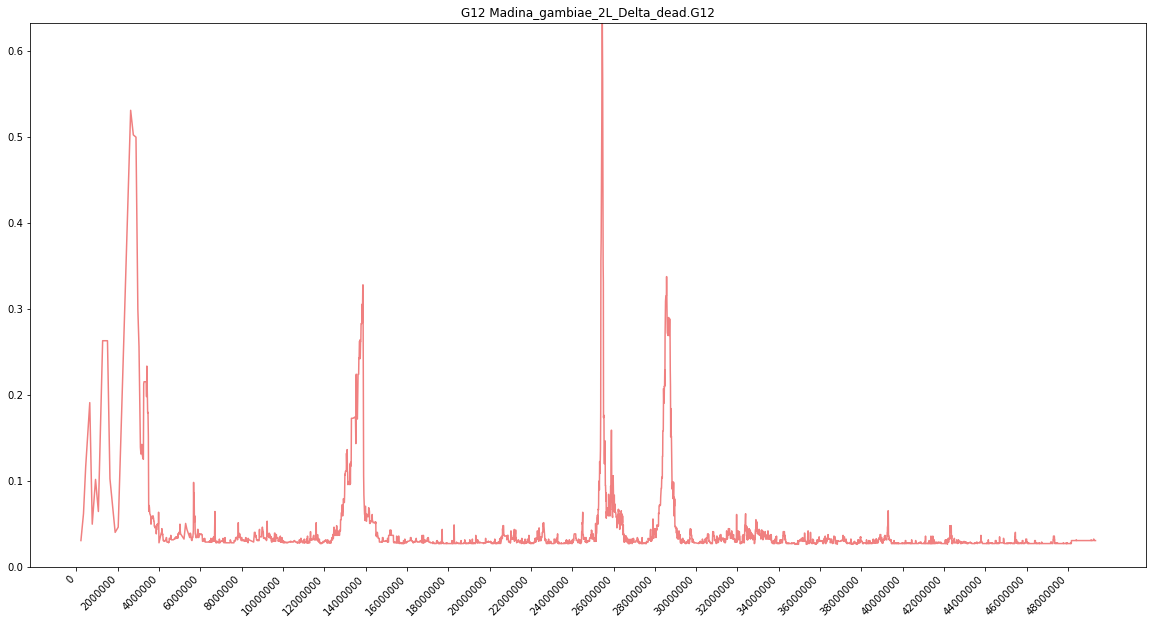

/home/conda/store/17f40134658659e5d865c50a7260f8dc9b3903da365e6d18c462a8ab32cb5d2d-binder-v3.1.0/lib/python3.8/site-packages/dask/array/routines.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return a[(slice(None),) * axis + (indices,)]


--------- Running G12 on Madina gambiae Chromosome 2L Delta alive----------
There are 3870705 segregating sites and 79 individuals


/home/conda/store/17f40134658659e5d865c50a7260f8dc9b3903da365e6d18c462a8ab32cb5d2d-binder-v3.1.0/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


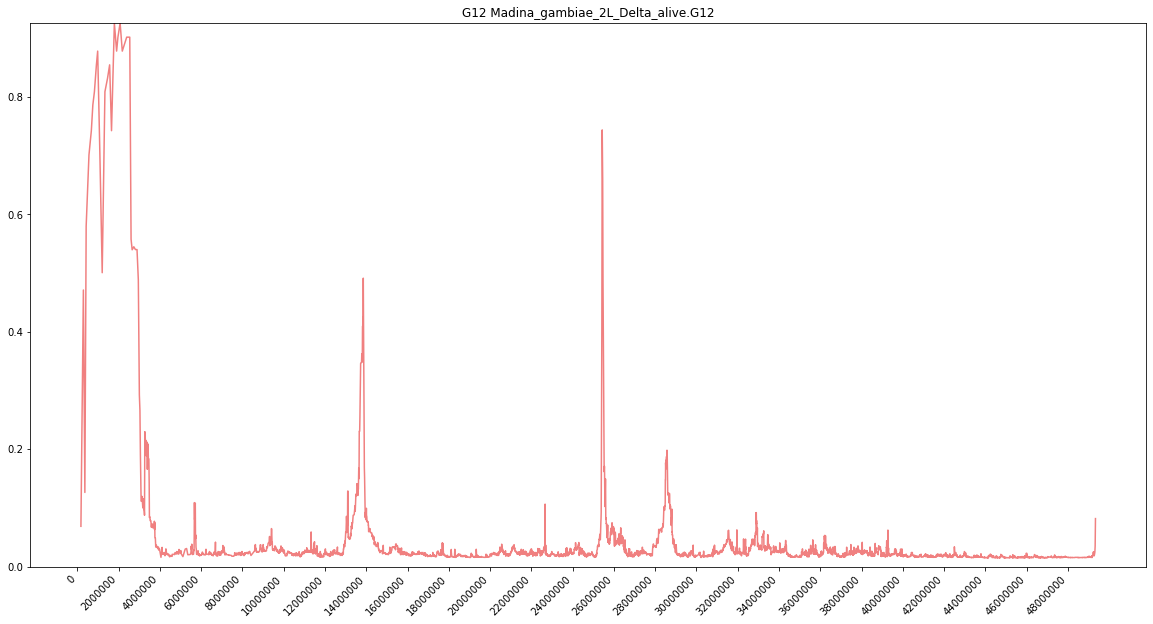

--------- Running G12 on Madina gambiae Chromosome 2L PM dead----------
There are 2824620 segregating sites and 33 individuals


In [ ]:
for chrom in chroms:
    
    ## Load site filters, Genotype and POS arrays and filter
    gambcolu_filter = ag3.site_filters(mask="gamb_colu", contig=chrom)
    snps = allel.GenotypeDaskArray(ag3.snp_genotypes(contig=chrom, sample_sets='1244-VO-GH-YAWSON-VMF00051')).compress(gambcolu_filter, axis=0)
    pos = ag3.snp_sites(contig=chrom)
    pos = allel.SortedIndex(pos[0])[gambcolu_filter]
    
    # Count alleles per site
    ac = snps.count_alleles()
    # Get boolean array for biallelic or not
    bial_bool = ac.is_biallelic()
    # Filter arrays to biallelic only
    snps = snps.compress(bial_bool, axis=0)
    positions = pos[bial_bool]


    for loc in metadata.location.unique():

        nmeta = metadata[metadata.location == loc]

            # have edited .species_gambiae_coluzzii column to contain 'arabiensis' instead of NA 
        for sp in nmeta.species_gambiae_coluzzii.unique():

            # if there is less than n samples then skip
            if (nmeta.species_gambiae_coluzzii == sp).sum() <= 12:
                continue
            #filter to species 
            nmeta2 = nmeta[nmeta.species_gambiae_coluzzii == sp]
                
            for ins in nmeta2.insecticide.unique():
                
                nmeta3 = nmeta2[nmeta2.insecticide == ins]
                
                for pheno in nmeta3.phenotype.unique():

                    # if file exists ignore and skip
                    myfile = Path(f"gaard/{loc}_{sp}_{chrom}_{ins}_{pheno}.G12.png")
                    if myfile.is_file():
                        print(f"skipping {loc}_{sp}_{chrom}_{ins}_{pheno}, as already done.")
                        continue

                    nmeta4 = nmeta3[nmeta3.phenotype == pheno]
                    flt = np.array(nmeta4.index)
                    # filter to correct loc, year, species individuals
                    gn = snps.take(flt, axis=1)

                    print(f"--------- Running G12 on {loc} {sp} Chromosome {chrom} {ins} {pheno}----------")

                    # filter to segregating sites only as the phase 3 arrays contain every SNP on the chromosome
                    seg = gn.count_alleles().is_segregating()
                    gn = gn.compress(seg, axis=0)
                    pos = positions[seg]

                    print(f"There are {gn.shape[0]} segregating sites and {gn.shape[1]} individuals")

                    # convert to 0,1,2 genotypes
                    gn_alt = gn.to_n_alt().compute()

                    # calculate G12 and plot figs 
                    garuds_G12(gnalt=gn_alt, pos=pos, cut_height=6,
                               save=True, 
                               prefix='gaard',
                               name=f"{loc}_{sp}_{chrom}_{ins}_{pheno}.G12", 
                               metric='euclidean',
                              window_size=1000,
                              step_size=500, cluster=True, species=sp)